In [2]:
import os
import numpy as np
import pandas as pd 
import sys
#import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import dill as pickle

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)


import allensdk
import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.utils import get_aligned_ids
from mcmodels.core import VoxelModelCache
from mcmodels.connectivity.creation import get_connectivity_matrices3
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss, Crossval
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists

def get_row_col_names(connectivity_data, target_ordering):
    
    rnames = np.asarray([ia_map[target_ordering[i]] for i in range(len(target_ordering))])
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
    cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])
    ccomb = np.vstack([np.concatenate([np.repeat('ipsi',connectivity_data.ipsi_target_regions.shape[0]),
                                       np.repeat('contra',connectivity_data.contra_target_regions.shape)]), cnames])
    ccomb = np.asarray(ccomb)
    tuples2 = list(zip(*ccomb))
    cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])
    return(cnam_multi, rnames)

#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/major_structures.npy')
major_structure_ids = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/major_structure_ids.npy')
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
ontological_order_leaves = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_leaves_v3.npy')
ontological_order = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_v3.npy')
ontological_order_leaves_majors = get_aligned_ids(st,ontological_order_leaves,major_structure_ids)
ontological_order_leaves_summary = get_aligned_ids(st,ontological_order_leaves,ontological_order)

connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, structure_set_id=167587189)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(major_structure_ids)

connectivity_data.ai_map = ai_map
connectivity_data.get_crelines(data_info)
connectivity_data.get_summarystructures(data_info)
connectivity_data.summary_structures = {sid: connectivity_data.structure_datas[sid].summary_structures for sid in major_structure_ids}#get_indices_2ormore(connectivity_data.leafs)
connectivity_data.leafs = leafs

sid0 = list(connectivity_data.structure_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
targ_ord = ontological_order_leaves
source_ord = ontological_order_leaves
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=1)
#ontological_order = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_v3.npy')
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=2)
connectivity_data.get_regionalized_normalized_data(source_ord, ipsi_targetkey, contra_targetkey)
summary_structures = {sid: connectivity_data.structure_datas[sid].summary_structures for sid in major_structure_ids}#get_indices_2ormore(connectivity_data.leafs)

#el_leafsurf_leafsmth_v3_leafleaf_

experiment_sids_surfaces = summary_structures
experiment_sids_nws = leafs
model_ordering = ontological_order_leaves_majors
source_ordering_surface = ontological_order_leaves_summary
source_ordering_nw = ontological_order_leaves
source_ordering = ontological_order_leaves
target_ordering = ontological_order_leaves
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]
    
with open(workingdirectory + '/paper/trainedmodels/ELleaf_surface_0427_leafleaf2.pickle', 'rb') as handle:
    surfaces = pickle.load(handle)
 
#source_reg = np.asarray(['MOp2/3', 'MOp5', 'MOp6a','MOs2/3', 'MOs5', 'MOs6a' ])
eval_cre_list = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
#eval_cre_list = np.unique(np.concatenate(list(connectivity_data.creline.values())))
#eval_cre_list = np.setdiff1d(eval_cre_list,eval_cre_list_old)
cnam_multi, rnames = get_row_col_names(connectivity_data, ontological_order_leaves)
eval_cre_names =  ['C57BL6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
#eval_cre_list


annotation/ccf_2017
512
703
1089
1097
315
313
354
698
771
803
477
549


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:225: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(reg_inj_vcount_norm, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:225: RuntimeWarning: invalid value encountered in true_divide
  np.sum(reg_inj_vcount_norm, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:229: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(reg_ipsi_inj, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:229: RuntimeWarning: invalid value encountered in true_divide
  np.sum(reg_ipsi_inj, axis=1), 1)


In [4]:
np.where(rnames == 'MOp6a')[0]

array([8])

In [ ]:
c = eval_cre_list[0]

(array([315]), array([985]), array([844.]), array([844.]))

In [17]:
source_ordering_surface[8:9],source_ordering_nw[8:9]

(array([985]), array([844.]))

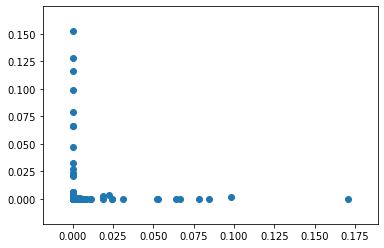

In [36]:
plt.scatter(conn_v3[0],connectivity_data.structure_datas[315].reg_proj_norm[leaf_ind].mean(axis = 0))

In [38]:
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions
    ipsi_indices = np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering:
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions == iy)[0]])
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions == iy)[0]])
    ipsi_indices = np.asarray(ipsi_indices, dtype=int)
    contra_indices = np.asarray(contra_indices, dtype=int)
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])

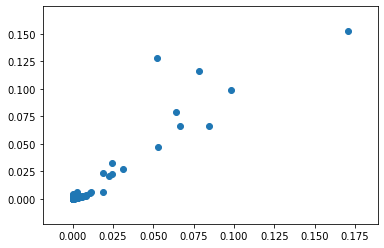

In [56]:
plt.scatter(conn_v3[0],connectivity_data.structure_datas[315].reg_proj_norm[leaf_ind[0]].mean(axis = 0)[reorder])

In [55]:
means = pd.DataFrame(np.expand_dims(connectivity_data.structure_datas[315].reg_proj_norm[leaf_ind[0]].mean(axis = 0)[reorder],0), index=rnames[8:9],columns = cnam_multi)

In [57]:
means_ntsr1 = pd.DataFrame(np.expand_dims(connectivity_data.structure_datas[315].reg_proj_norm[leaf_ind[0][[0,2]]].mean(axis = 0)[reorder],0), index=rnames[8:9],columns = cnam_multi)

In [69]:
means_other = pd.DataFrame(np.expand_dims(connectivity_data.structure_datas[315].reg_proj_norm[leaf_ind[0][[1]]].mean(axis = 0)[reorder],0), index=rnames[8:9],columns = cnam_multi)

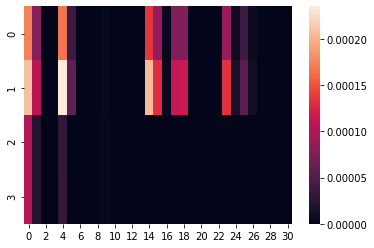

In [70]:
sns.heatmap(np.squeeze(np.asarray([means.loc[:,targ_reg],
means_ntsr1.loc[:,targ_reg],
means_other.loc[:,targ_reg],
connectivity_matrices.loc[:,targ_reg]])))

In [75]:
strs = leafs[315][np.where(connectivity_data.creline[315] == 'Syt6-Cre_KI148')[0]]

In [81]:
np.where( np.asarray([ia_map[strs[i]] for i in range(len(strs))]) == 'MOp6a')[0]

array([12])

In [82]:
np.where( np.asarray([ia_map[strs[i]] for i in range(len(strs))]) == 'MOp5')[0]

array([37, 41])

In [84]:
np.where(connectivity_data.creline[315] == 'Syt6-Cre_KI148')[0][[12,37,41]]

array([153, 774, 891])

In [107]:
means_Syt6 = pd.DataFrame(np.expand_dims(connectivity_data.structure_datas[315].reg_proj_norm[[153, 774, 891]].mean(axis = 0)[reorder],0), index=rnames[7:8],columns = cnam_multi)

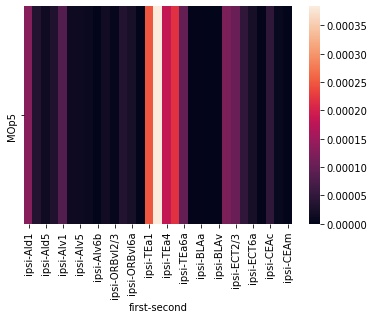

In [108]:
sns.heatmap(means_Syt6.loc[:,targ_reg])

In [117]:
ass = np.where(connectivity_data.creline[315] == 'Ntsr1-Cre_GN220')[0]
bss = np.where(connectivity_data.summary_structures[315] == 985)[0]
ntss = np.intersect1d(ass,bss)

In [119]:
css = np.where(connectivity_data.creline[315] == 'C57BL/6J')[0]
bss = np.where(connectivity_data.summary_structures[315] == 985)[0]

In [120]:
wti = np.intersect1d(css,bss)

In [121]:
means_ntsr1 = pd.DataFrame(np.expand_dims(connectivity_data.structure_datas[315].reg_proj_norm[ntss].mean(axis = 0)[reorder],0), index=rnames[7:8],columns = cnam_multi)

In [122]:
means_wa = pd.DataFrame(np.expand_dims(connectivity_data.structure_datas[315].reg_proj_norm[wti].mean(axis = 0)[reorder],0), index=rnames[7:8],columns = cnam_multi)

In [123]:
np.linalg.norm(means_ntsr1 - means_wa)

0.28191804145203725

In [124]:
np.linalg.norm(means_Syt6 - means_wa)

0.1958459676220996

In [142]:
combbbb = pd.concat([means_ntsr1, means_Syt6,means_wa])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


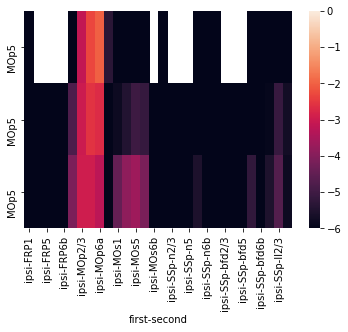

In [149]:
sns.heatmap(np.log(combbbb.iloc[:,:30]), vmin = -6, vmax= 0)

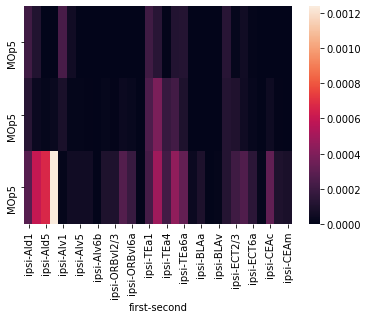

In [143]:
sns.heatmap(combbbb.loc[:,targ_reg])

In [135]:
sns.heatmap([means_Syt6.loc[:,targ_reg], means_ntsr1[:,targ_reg], means_wa[:,targ_reg]])

TypeError: '(slice(None, None, None), [('ipsi', 'AId1'), ('ipsi', 'AId2/3'), ('ipsi', 'AId5'), ('ipsi', 'AId6a'), ('ipsi', 'AIv1'), ('ipsi', 'AIv2/3'), ('ipsi', 'AIv5'), ('ipsi', 'AIv6a'), ('ipsi', 'AIv6b'), ('ipsi', 'ORBvl1'), ('ipsi', 'ORBvl2/3'), ('ipsi', 'ORBvl5'), ('ipsi', 'ORBvl6a'), ('ipsi', 'ORBvl6b'), ('ipsi', 'TEa1'), ('ipsi', 'TEa2/3'), ('ipsi', 'TEa4'), ('ipsi', 'TEa5'), ('ipsi', 'TEa6a'), ('ipsi', 'TEa6b'), ('ipsi', 'BLAa'), ('ipsi', 'BLAp'), ('ipsi', 'BLAv'), ('ipsi', 'ECT1'), ('ipsi', 'ECT2/3'), ('ipsi', 'ECT5'), ('ipsi', 'ECT6a'), ('ipsi', 'ECT6b'), ('ipsi', 'CEAc'), ('ipsi', 'CEAl'), ('ipsi', 'CEAm')])' is an invalid key

In [106]:
np.intersect1d(ass,bss)

array([  5, 734])

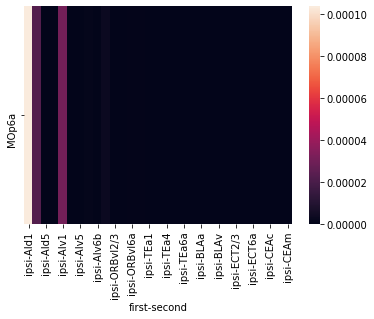

In [94]:
means_other = pd.DataFrame(np.expand_dims(connectivity_data.structure_datas[315].reg_proj_norm[[153]].mean(axis = 0)[reorder],0), index=rnames[8:9],columns = cnam_multi)
sns.heatmap(means_other.loc[:,targ_reg])

In [71]:
connectivity_data.creline[315][leaf_ind[0][[1]]]

array(['Syt6-Cre_KI148'], dtype=object)

In [42]:
targ_reg = [('ipsi',      'AId1'),
('ipsi',    'AId2/3'),
('ipsi',      'AId5'),
('ipsi',     'AId6a'),
('ipsi',      'AIv1'),
('ipsi',    'AIv2/3'),
('ipsi',      'AIv5'),
('ipsi',     'AIv6a'),
('ipsi',     'AIv6b'),
('ipsi',    'ORBvl1'),
('ipsi',  'ORBvl2/3'),
('ipsi',    'ORBvl5'),
('ipsi',   'ORBvl6a'),
('ipsi',   'ORBvl6b'),
('ipsi',     'TEa1'),
('ipsi',   'TEa2/3'),
('ipsi',     'TEa4'),
('ipsi',     'TEa5'),
('ipsi',    'TEa6a'),
('ipsi',    'TEa6b'),
('ipsi',     'BLAa'),
('ipsi',     'BLAp'),
('ipsi',     'BLAv'),
('ipsi',     'ECT1'),
('ipsi',   'ECT2/3'),
('ipsi',     'ECT5'),
('ipsi',    'ECT6a'),
('ipsi',    'ECT6b'),
('ipsi',   'CEAc'),
('ipsi',   'CEAl'),
('ipsi',   'CEAm')]

In [9]:
    c  = 0
    print(c, eval_cre_list[c])
    conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws,model_ordering[8:9], source_ordering_surface[8:9], source_ordering_nw[8:9], source_ordering[8:9], target_ordering, [eval_cre_list[c]])
    connectivity_matrices = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames[8:9])
    #connectivity_matrices.to_csv(workingdirectory + '/paper/connectivities/el_sumsurf_leafsmth_leafleaf_' + str(eval_cre_names[c]) + '0428.csv')


0 C57BL/6J
0 844.0


In [26]:
connectivity_matrices.loc['MOp6a']

first   second
ipsi    FRP1      4.628515e-09
        FRP2/3    2.660361e-06
        FRP5      1.223329e-05
        FRP6a     1.997782e-05
        FRP6b     3.091387e-06
                      ...     
contra  FL        2.117784e-05
        FN        1.139790e-07
        IP        7.818304e-07
        DN        0.000000e+00
        VeCB      7.671334e-07
Name: MOp6a, Length: 1123, dtype: float64

In [22]:
connectivity_data.creline[315]

array(['Rbp4-Cre_KL100', 'Nr5a1-Cre', 'Sim1-Cre_KJ18', ..., 'C57BL/6J',
       'Tlx3-Cre_PL56', 'C57BL/6J'], dtype=object)

In [23]:
sum_ind = np.where(experiment_sids_surfaces[315] == 985)
leaf_ind = np.where(experiment_sids_nws[315]  == 844)


array([4.27947520e-05, 2.99017514e-06, 1.58263648e-05, ...,
       1.01331261e-07, 1.64050952e-06, 6.37426447e-06])

In [27]:
connectivity_data.creline[315][leaf_ind]

array(['Ntsr1-Cre_GN220', 'Syt6-Cre_KI148', 'Ntsr1-Cre_GN220'],
      dtype=object)

In [24]:
connectivity_data.creline[315][sum_ind]

array(['Ntsr1-Cre_GN220', 'C57BL/6J', 'Syt6-Cre_KI148', 'Nr5a1-Cre',
       'Rbp4-Cre_KL100', 'Crh-IRES-Cre_BL', 'A930038C07Rik-Tg1-Cre',
       'Cux2-IRES-Cre', 'C57BL/6J', 'Chrna2-Cre_OE25', 'C57BL/6J',
       'C57BL/6J', 'Scnn1a-Tg3-Cre', 'C57BL/6J', 'C57BL/6J', 'C57BL/6J',
       'Tlx3-Cre_PL56', 'Npr3-IRES2-Cre', 'Efr3a-Cre_NO108',
       'Sim1-Cre_KJ18', 'Ntsr1-Cre_GN220', 'Htr2a-Cre_KM207',
       'Syt6-Cre_KI148', 'Calb1-T2A-dgCre', 'Sim1-Cre_KJ18',
       'Syt6-Cre_KI148', 'Sim1-Cre_KJ18', 'C57BL/6J',
       'A930038C07Rik-Tg1-Cre', 'Chrna2-Cre_OE25'], dtype=object)

In [12]:
def fix_pdcsv(csv):
    
    #wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

In [13]:
wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_sumsurf_leafsmth_leafleaf_C57BL6J0428.csv',   header=[0, 1])
wt_conn = fix_pdcsv(wt_conn)


In [32]:
wt_conn.shape

(564, 1123)

In [14]:
wt_conn.loc['MOp6a']

ipsi    FRP1      4.628515e-09
        FRP2/3    2.660361e-06
        FRP5      1.223329e-05
        FRP6a     1.997782e-05
        FRP6b     3.091387e-06
                      ...     
contra  FL        2.117784e-05
        FN        1.139790e-07
        IP        7.818304e-07
        DN        0.000000e+00
        VeCB      7.671334e-07
Name: MOp6a, Length: 1123, dtype: float64

In [ ]:

for c in range(len(eval_cre_list)):
    print(c, eval_cre_list[c])
    conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
    connectivity_matrices = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames)
    connectivity_matrices.to_csv(workingdirectory + '/paper/connectivities/el_sumsurf_leafsmth_leafleaf_' + str(eval_cre_names[c]) + '0428.csv')
    
